# Converting Images to Point Cloud
This notebook demonstrates how to convert images to point clouds using the [Open3D](http://www.open3d.org/) library. The images are first converted to depth maps using a pre-trained model, and then the depth maps are converted to point clouds. The point clouds are then visualized using Open3D.

In [119]:
import os
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np 
from numpy import asarray
from transformers import pipeline
from PIL import Image

#### Import data
The data is imported from the `input` directory. These images are transformed to depth maps (saved in the `depth` directory) and then to point clouds (saved in the `point_cloud` directory).

In [120]:
input_path = "input/"
output_dir = "output/depth/"

dir_list = os.listdir(input_path)
original_paths = []
depth_map_pahts = []
for filename in dir_list:
    if filename != None and filename.endswith(('.png')):
        image_path = input_path + filename
        output_path = output_dir + filename.split('.')[0] + '_depth.png'
        original_paths.append(image_path)
        depth_map_pahts.append(output_path)
df_paths = pd.DataFrame({'Original': original_paths, 'DepthMap': depth_map_pahts})

#### Transform images to depth maps
Function to convert images to depth maps:

In [121]:
def make_8bit_image(depth_map_array):
    max_pixel_value = depth_map_array.max()
    depth_map_array = depth_map_array / max_pixel_value * 255
    depth_map_array = depth_map_array.astype('uint8')
    return depth_map_array

def save_image(depth_map_array, output_path):
    image = Image.fromarray(depth_map_array)
    image.save(output_path)

def img_to_depth_map(depth_estimation_pipeline, image_path, output_path):
    # load input image
    image = Image.open(image_path)
    if image.size != (640, 480):
        image = image.resize((640, 480))

    # Realizar la estimación de profundidad en la imagen de entrada
    depth_map = depth_estimation_pipeline(image)

    # access the predicted depth map
    depth_map_tensor = depth_map['predicted_depth']

    # Convertir el tensor de profundidad en una matriz numpy y mostrarlo
    depth_map_array = depth_map_tensor[0].numpy()
    depth_map_array = make_8bit_image(depth_map_array)

    # show_depth_map(depth_map_array)
    save_image(depth_map_array, output_path)

Load the depth-estimation pipeline

In [122]:
depth_estimation_pipeline = pipeline("depth-estimation", model="vinvino02/glpn-nyu")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Then apply the pipeline to the images in the `input` directory and save the depth maps in the `depth` directory.

In [123]:
df_paths.apply(lambda row: img_to_depth_map(depth_estimation_pipeline, row["Original"], row['DepthMap']), axis=1)

0    None
1    None
2    None
3    None
4    None
dtype: object

#### Visualize Depth Map Results

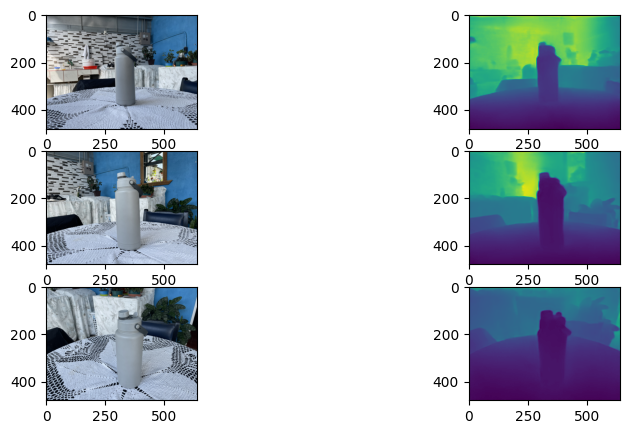

In [124]:
#display images and its maps
df_sample = df_paths.sample(3)
x, y = df_sample.shape
fig, axs = plt.subplots(x, y, figsize=(10, 5))
for i, (index, row) in enumerate(df_sample.iterrows()):
    original_image = imread(row['Original'])
    depth_map = imread(row['DepthMap'])
    axs[i, 0].imshow(original_image)
    axs[i, 1].imshow(depth_map)

#### Transform Depth Maps into Point Clouds

Build the path to the point cloud directory for every image in the `depth` directory.

In [125]:
def build_pc_output_path(image_path):
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    return os.path.join('output/pcd/', image_name + '.ply')

df_paths["PointCloud"] = df_paths["Original"].apply(build_pc_output_path)


Function to convert depth maps to point clouds.
The camera parameteres doesn't correspond to the real camera parameters, but they are used to generate the point cloud.

In [126]:
def depth_to_pcd(depth_path, pcd_path):
    # Depth camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02
    
    depth_image = Image.open(depth_path).convert('L')
    depth_image = asarray(depth_image)
    
    # get depth resolution:
    height, width = depth_image.shape
    length = height * width
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_image.reshape(length)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))

    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd)

    o3d.io.write_point_cloud(pcd_path, pcd_o3d)


Transform the depth maps to point clouds and save them in the `point_cloud` directory.

In [127]:
y = df_paths.apply(lambda row: depth_to_pcd(row["DepthMap"], row["PointCloud"]), axis=1)

#### Visualize Sample Point Clouds

In [128]:
sample = df_paths.sample(1)

We take a random sample and visualize the point clouds.

In [129]:
path_to_pcd = sample["PointCloud"].values[0]
pcd = o3d.io.read_point_cloud(path_to_pcd)
o3d.visualization.draw_geometries([pcd])
# o3d.visualization.draw_plotly([pcd])

In [130]:
def extract_color_image(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = asarray(img)
    img = img/255.0 # normalize RGB values to [0, 1]

    height, width, channels = img.shape
    length = height * width

    color_list = img.reshape((length, channels)) # array of RGB values
    return color_list

We can add the original image color to the point cloud.

In [131]:
path_to_original = sample["Original"].values[0]
colors = extract_color_image(path_to_original)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pcd])
# o3d.visualization.draw_plotly([pcd])